In [1]:
import os

import openmm as mm
from openmm.app import *
from openmm import unit
from openmm import app
from pdbfixer import PDBFixer
import mdtraj as md
import nglview as nv
import requests
import numpy as np
from math import sqrt
from tqdm import tqdm
import matplotlib.pyplot as plt

# Barnase-Barstar Simulation

## System Analysis

In [2]:
# Function to download PDB files

def fetch_pdb(pdb_id, download_path="./"):

        url = 'http://files.rcsb.org/download/{}.pdb'.format(pdb_id)
        try:
            res = requests.get(url, allow_redirects=True)
        except:
            print("Could not fetch pdb from {}".format(url))
            return 
        
        file_path = os.path.join(download_path, pdb_id + ".pdb")
        with open(file_path, "wb") as f:
            f.write(res.content)

In [3]:
# Just write the PDB id in order to download the pdb file

fetch_pdb("1brs")

In [4]:
# Load pdb with MDTraj

brs = md.load('1brs.pdb')

In [5]:
# Remove water molecules

brs = brs.remove_solvent()

In [6]:
brs.topology

<mdtraj.Topology with 6 chains, 588 residues, 4638 atoms, 4740 bonds at 0x7fae73bc0bb0>

In [7]:
# Barnase's chains

atoms_in_chain_A = brs.topology.select("chainid == 0")
atoms_in_chain_B = brs.topology.select("chainid == 1")
atoms_in_chain_C = brs.topology.select("chainid == 2")

In [8]:
# Barstar's chains

atoms_in_chain_D = brs.topology.select("chainid == 3")
atoms_in_chain_E = brs.topology.select("chainid == 4")
atoms_in_chain_F = brs.topology.select("chainid == 5")

In [9]:
# Barnase's chain's atoms

barnase_A = brs.atom_slice(atoms_in_chain_A)
barnase_B = brs.atom_slice(atoms_in_chain_B)
barnase_C = brs.atom_slice(atoms_in_chain_C)

In [10]:
# Barstar's chain's atoms

barstar_D = brs.atom_slice(atoms_in_chain_D)
barstar_E = brs.atom_slice(atoms_in_chain_E)
barstar_F = brs.atom_slice(atoms_in_chain_F)

In [11]:
print(f'Barnase has {barnase_A.n_atoms} atoms and {barnase_A.n_residues} residues in A')
print(f'Barnase has {barnase_B.n_atoms} atoms and {barnase_B.n_residues} residues in B')
print(f'Barnase has {barnase_C.n_atoms} atoms and {barnase_C.n_residues} residues in C')

Barnase has 864 atoms and 108 residues in A
Barnase has 878 atoms and 110 residues in B
Barnase has 839 atoms and 108 residues in C


In [12]:
print(f'Barstar has {barstar_D.n_atoms} atoms and {barstar_D.n_residues} residues in D')
print(f'Barstar has {barstar_E.n_atoms} atoms and {barstar_E.n_residues} residues in E')
print(f'Barstar has {barstar_F.n_atoms} atoms and {barstar_F.n_residues} residues in F')

Barstar has 693 atoms and 87 residues in D
Barstar has 665 atoms and 86 residues in E
Barstar has 699 atoms and 89 residues in F


<div class="alert alert-info">
<strong>NOTE:</strong> We conclude chain B and F will be optimal to work.
</div>


In [13]:
view = nv.show_mdtraj(brs)
view

NGLWidget()

<div class="alert alert-info">
<strong>NOTE:</strong> Superpose F with E.
</div>

## System Preparation

In [14]:
ca_in_chain_E = brs.topology.select("chainid == 4 and name CA")
ca_in_chain_F = brs.topology.select("chainid == 5 and name CA")

In [15]:
chain_E = brs.atom_slice(ca_in_chain_E)
chain_F = brs.atom_slice(ca_in_chain_F)

In [16]:
ca_name_in_E = []
for atom in chain_E.topology.atoms_by_name('CA'):
    ca_name_in_E.append(str(atom))

In [17]:
ca_name_in_F = []
for atom in chain_F.topology.atoms_by_name('CA'):
    ca_name_in_F.append(str(atom))

In [18]:
index = []

for x in ca_name_in_F:    #Lista grande
    for y in ca_name_in_E:    #Lista pequeña
        if x in y:
            index.append(True)
            break
    else:
        index.append(False)

In [19]:
ca_in_chain_G = []

for uu in range(len(index)):
    if index[uu] == True:
        ca_in_chain_G.append(ca_in_chain_F[uu])
        
ca_in_chain_G = np.array(ca_in_chain_G)

In [20]:
traj_E = brs.atom_slice(ca_in_chain_E)
traj_E

<mdtraj.Trajectory with 1 frames, 86 atoms, 86 residues, and unitcells at 0x7fae73924e50>

In [21]:
traj_F = brs.atom_slice(ca_in_chain_G)
traj_F

<mdtraj.Trajectory with 1 frames, 86 atoms, 86 residues, and unitcells at 0x7fae73554bb0>

In [22]:
brstr_to_B = md.Trajectory.superpose(traj_F, traj_E, frame=0)

In [23]:
pp = nv.show_mdtraj(brstr_to_B)
pp

NGLWidget()

In [24]:
qq = nv.show_mdtraj(barnase_B)
qq

NGLWidget()

In [25]:
brns_brstr = barnase_B.stack(brstr_to_B)

In [26]:
uu = nv.show_mdtraj(brns_brstr)
uu

NGLWidget()

In [27]:
brns_brstr.save_pdb('brs.pdb')

In [28]:
fixer = PDBFixer(filename='brs.pdb')

In [29]:
fixer.topology

<Topology; 2 chains, 196 residues, 964 atoms, 899 bonds>

In [30]:
fixer.findMissingResidues()
missing_residues = fixer.missingResidues
print(f"{len(missing_residues)} missing residues")

fixer.findNonstandardResidues()
nonstandard_residues = fixer.nonstandardResidues
print(f"{len(nonstandard_residues)} non standard residues")

fixer.findMissingAtoms()
missing_atoms = fixer.missingAtoms
missing_terminals = fixer.missingTerminals
print(f"{len(missing_atoms)} missing atoms")
print(f"{len(missing_terminals)} missing terminals")

if len(nonstandard_residues)>0:
    fixer.replaceNonstandardResidues()

if len(missing_atoms)>0:
    fixer.addMissingAtoms()

0 missing residues
0 non standard residues
86 missing atoms
1 missing terminals


In [31]:
forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3p.xml')

In [32]:
modeller = app.Modeller(fixer.topology, fixer.positions)
pH = 7.2
residues_protonated = modeller.addHydrogens(forcefield=forcefield, pH=pH)

In [33]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.NoCutoff)

charge = 0.0 * unit.elementary_charge
for force_index in range(system.getNumForces()):
    force = system.getForce(force_index)
    if isinstance(force, mm.NonbondedForce):
        for index in range(system.getNumParticles()):
            charge+=force.getParticleParameters(int(index))[0]

charge = np.round(charge._value)*charge.unit

In [34]:
charge

Quantity(value=-4.0, unit=elementary charge)

In [35]:
app.PDBFile.writeFile(modeller.topology, modeller.positions, open('brs_full.pdb', 'w'))

In [36]:
uu = md.load("brs_full.pdb")
view = nv.show_mdtraj(uu)
view

NGLWidget()

In [37]:
# Solvate system

pdb = app.PDBFile('brs_full.pdb')
forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3p.xml')
modeller = app.Modeller(pdb.topology, pdb.positions)

In [38]:
geompadding = 1.4 * unit.nanometers
maxSize = max(max((pos[i] for pos in pdb.positions))-min((pos[i] for pos in pdb.positions)) for i in range(3))
vectors = mm.Vec3(1,0,0), mm.Vec3(1/3,2*sqrt(2)/3,0), mm.Vec3(-1/3,sqrt(2)/3,sqrt(6)/3)
boxVectors = [(maxSize+geompadding)*v for v in vectors]

In [39]:
modeller.addSolvent(forcefield, model='tip3p', boxVectors=boxVectors)

In [40]:
app.PDBFile.writeFile(modeller.topology, modeller.positions, open('brs_solv.pdb', 'w'))

In [41]:
uu = md.load_pdb('brs_solv.pdb')
view = nv.show_mdtraj(uu)
view.add_licorice(selection='water')
view

NGLWidget()

## System Minimization

In [42]:
pdb = PDBFile('brs_solv.pdb') # Sistema Solvatado

In [43]:
pdb_v = PDBFile('brs_full.pdb') #Sistema Vacio

In [44]:
pdb_a = PDBFile('brs_a.pdb')
pdb_b = PDBFile('brs_b.pdb')

In [47]:
forcefield = ForceField('amber14-all.xml', 'amber14/tip3p.xml')

In [48]:
system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME, nonbondedCutoff=1.2*unit.nanometer, switchDistance=0.9*unit.nanometer, constraints=HBonds)

In [49]:
system_v = forcefield.createSystem(pdb_v.topology, constraints=HBonds)

In [50]:
system_a = forcefield.createSystem(pdb_a.topology, constraints=HBonds)
system_b = forcefield.createSystem(pdb_b.topology, constraints=HBonds)

In [51]:
n_particles  = pdb.topology.getNumAtoms()
nv_particles = pdb_v.topology.getNumAtoms()
na_particles = pdb_a.topology.getNumAtoms()
nb_particles = pdb_b.topology.getNumAtoms()

In [52]:
# Definición del estado termodinámico y el integrador, para sistema solvatado

step_size   = 0.002*unit.picoseconds
temperature = 300*unit.kelvin
friction    = 1.0/unit.picosecond # Damping para la dinámica de Langevin

integrator = mm.LangevinIntegrator(temperature, friction, step_size)

In [53]:
# Definición del estado termodinámico y el integrador, para sistema vacio

step_size_v   = 0.002*unit.picoseconds
temperature_v = 0.0*unit.kelvin
friction_v    = 0.0/unit.picosecond # Damping para la dinámica de Langevin

integrator_v = mm.LangevinIntegrator(temperature_v, friction_v, step_size_v)

In [54]:
# Definición del estado termodinámico y el integrador, para sistema A

step_size_a   = 0.002*unit.picoseconds
temperature_a = 0.0*unit.kelvin
friction_a    = 0.0/unit.picosecond # Damping para la dinámica de Langevin

integrator_a = mm.LangevinIntegrator(temperature_a, friction_a, step_size_a)

In [55]:
# Definición del estado termodinámico y el integrador, para sistema B

step_size_b   = 0.002*unit.picoseconds
temperature_b = 0.0*unit.kelvin
friction_b    = 0.0/unit.picosecond # Damping para la dinámica de Langevin

integrator_b = mm.LangevinIntegrator(temperature_b, friction_b, step_size_b)

In [56]:
# Creación de la plataforma.

platform_name = 'CUDA'
platform      = mm.Platform.getPlatformByName(platform_name)
platform_v    = mm.Platform.getPlatformByName(platform_name)
platform_a    = mm.Platform.getPlatformByName(platform_name)
platform_b    = mm.Platform.getPlatformByName(platform_name)

In [57]:
simulation = Simulation(pdb.topology, system, integrator, platform)

In [58]:
# Creación del objeto simulacion del sistema en vacio

simulation_v = Simulation(pdb_v.topology, system_v, integrator_v, platform_v)

In [59]:
# Creación del objeto simulacion de sistemas A y B

simulation_a = Simulation(pdb_a.topology, system_a, integrator_a, platform_a)
simulation_b = Simulation(pdb_b.topology, system_b, integrator_b, platform_b)

In [60]:
# Condiciones iniciales

simulation.context.setPositions(pdb.positions)
simulation_v.context.setPositions(pdb_v.positions)
simulation_a.context.setPositions(pdb_a.positions)
simulation_b.context.setPositions(pdb_b.positions)

In [61]:
# Minimizacion del sistema

simulation.minimizeEnergy()

In [62]:
# Parámetros de la simulación.

simulation_time = 0.1*unit.nanosecond
saving_time     = 10.0*unit.picoseconds

In [63]:
n_steps_per_period = int(saving_time/step_size) # número de pasos entre frame de guardado
n_periods          = int(simulation_time/saving_time) # número de frames guardados

In [64]:
# Creación de arrays reporteros del tiempo, la posición y la velocidad.

times                  = np.zeros([n_periods], np.float32) * unit.picoseconds
positions              = np.zeros([n_periods, n_particles, 3], np.float32) * unit.angstroms
pos_aux                = np.zeros([nv_particles,3], np.float32) * unit.angstroms
pos_aux_a              = np.zeros([na_particles,3], np.float32) * unit.angstroms
pos_aux_b              = np.zeros([nb_particles,3], np.float32) * unit.angstroms
potential_energies     = np.zeros([n_periods], np.float32) * unit.kilocalories_per_mole
potential_energies_v   = np.zeros([n_periods], np.float32) * unit.kilocalories_per_mole
potential_energies_a   = np.zeros([n_periods], np.float32) * unit.kilocalories_per_mole
potential_energies_b   = np.zeros([n_periods], np.float32) * unit.kilocalories_per_mole

In [65]:
# Almacenamiento en reporteros de las condiciones iniciales para tiempo 0

state                   = simulation.context.getState(getPositions=True, getEnergy=True)

times[0]                = state.getTime()
positions[0]            = state.getPositions()
potential_energies[0]   = state.getPotentialEnergy()

In [66]:
# Ejecuto el bucle sobre el número de periodos que vamos a simular

for ii in tqdm(range(1, n_periods)):
    simulation.context.getIntegrator().step(n_steps_per_period)
    state                    = simulation.context.getState(getPositions=True, getEnergy=True)
    times[ii]                = state.getTime()
    positions[ii]            = state.getPositions()
    potential_energies[ii]   = state.getPotentialEnergy()
    
    for tt in range(nv_particles):
        pos_aux[tt]          = state.getPositions()[tt]
        
    simulation_v.context.setPositions(pos_aux)
    
    state_v                  = simulation_v.context.getState(getEnergy=True)
    potential_energies_v[ii] = state_v.getPotentialEnergy()
    
    for uu in range(na_particles):
        pos_aux_a[uu]        = state.getPositions()[uu]
        
    simulation_a.context.setPositions(pos_aux_a)
    
    state_a                  = simulation_a.context.getState(getEnergy=True)
    potential_energies_a[ii] = state_a.getPotentialEnergy()
    
    for oo in range(nb_particles):
        pos_aux_b[oo]        = state.getPositions()[na_particles+oo]
        
    simulation_b.context.setPositions(pos_aux_b)
    
    state_b                  = simulation_b.context.getState(getEnergy=True)
    potential_energies_b[ii] = state_b.getPotentialEnergy()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:17<00:00, 15.29s/it]


Text(0.5, 0, 'time (picosecond)')

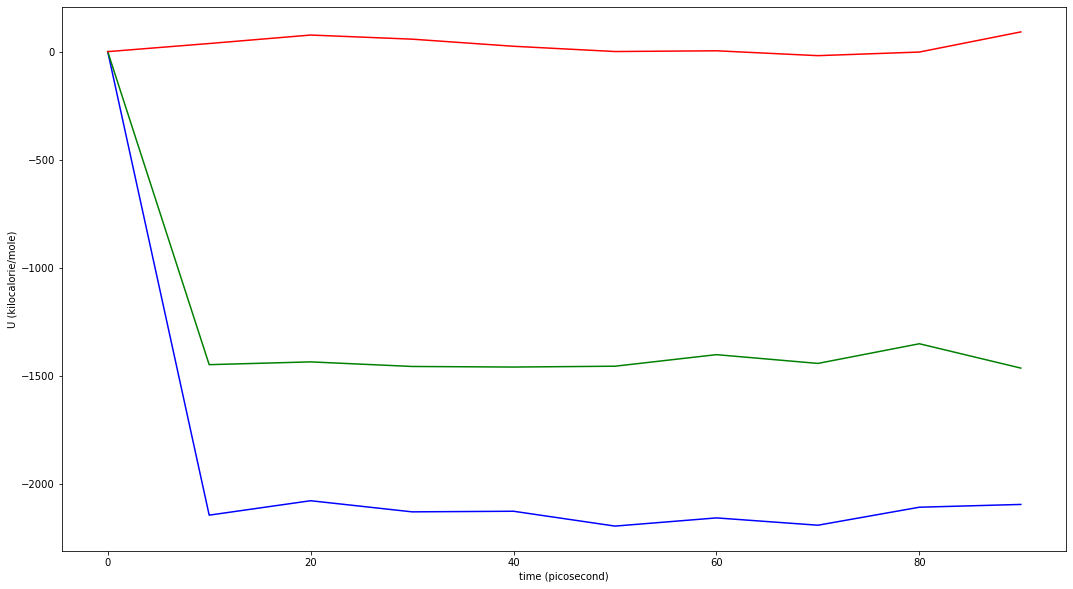

In [69]:
plt.rcParams['figure.figsize'] = 18, 10

#plt.plot(times, potential_energies, 'k')
plt.plot(times, potential_energies_v, 'b')
plt.plot(times, potential_energies_a, 'g')
plt.plot(times, potential_energies_b, 'r')
plt.ylabel('U ({})'.format(potential_energies.unit))
plt.xlabel('time ({})'.format(saving_time.unit))

In [71]:
potential_energies_a[1]+potential_energies_b[1]

Quantity(value=-1411.6122, unit=kilocalorie/mole)

In [72]:
potential_energies_v[1]

Quantity(value=-2145.8425, unit=kilocalorie/mole)